In [3]:
from data.loader import load_segmentation_dataset, load_train_dataset
from models.u2net.model import U2NET, export_u2net_model
from utils.display import display, DisplayCallback
from utils.metrics import RoundedAccuracy, RoundedMeanIoU, FBetaScore

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import keras

from keras.metrics import MeanSquaredError, Precision, Recall

tf.debugging.disable_traceback_filtering()
print("Available GPUs devices: ", tf.config.list_physical_devices('GPU'))

Available GPUs devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
TRAIN_DATASETS = ["DUTS-TR", "DIS5K\DIS-TE1", "DIS5K\DIS-TE2", "DIS5K\DIS-TE3", "DIS5K\DIS-TE4", "DIS5K\DIS-TR", "DIS5K\DIS-VD"]
TEST_PATH = "./datasets/DUTS-TE/"

IMAGE_SHAPE = (320, 320, 3)
MASK_SHAPE = (320, 320, 1)

# Training
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.001

In [7]:
train_dataset = load_train_dataset(
    dir_path = ["./datasets/{}/".format(i) for i in TRAIN_DATASETS],
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE,
    batch=BATCH_SIZE,
)

test_dataset = load_segmentation_dataset(
    dir_path = TEST_PATH,
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE,
    need_scaling = True
).batch(BATCH_SIZE)

# Изображение для отладки обучения
for images, masks in test_dataset.take(1):
    test_image_for_display = images[6]
    test_mask_for_display = masks[6]

2023-05-27 12:20:26.143244: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [8]:
def display_model_predictions(model: keras.Model):
    for image, mask in test_dataset.shuffle(80).take(1):
        out = model(image)
        for i in range(len(image)):
            out_mask = tf.math.round(out[0][i])
            display(
                [image[i], mask[i], np.multiply(image[i], out_mask), out_mask],
                ["Input image", "True mask", "Masked image", "Fused output mask"]
            )

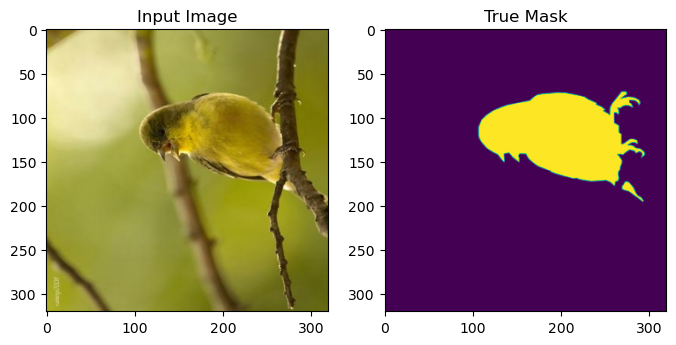

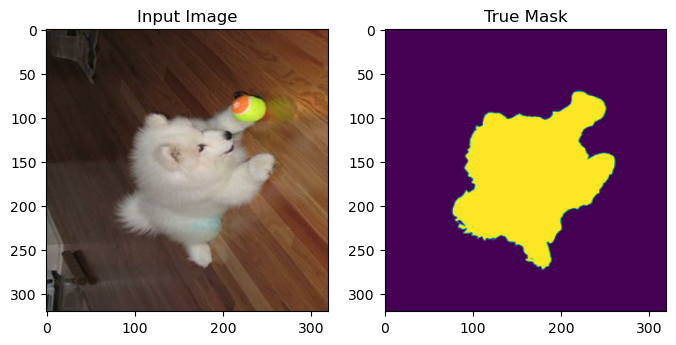

In [4]:
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask], ['Input Image', 'True Mask'], figsize=(8, 4))

In [8]:
adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=.9, beta_2=.999, epsilon=1e-08)
bce = keras.losses.BinaryCrossentropy()

model = U2NET()
model.compile(optimizer=adam, loss=bce, metrics=[
    [MeanSquaredError(), Precision(0.5), Recall(0.5), RoundedAccuracy(), RoundedMeanIoU(num_classes=2)]] + [None] * 6)

In [ ]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="./logs"),
    keras.callbacks.BackupAndRestore("./bkp"),
    keras.callbacks.ModelCheckpoint("./serving/models/u2net/2", monitor="val_activation_mean_squared_error", save_best_only=True),
    DisplayCallback(test_image_for_display, test_mask_for_display, 10, total_epochs=EPOCHS),
]

history = model.fit(train_dataset, validation_data=test_dataset, callbacks=callbacks, epochs=EPOCHS, verbose=1)
model.save('./serving/models/u2net/1', include_optimizer=False)

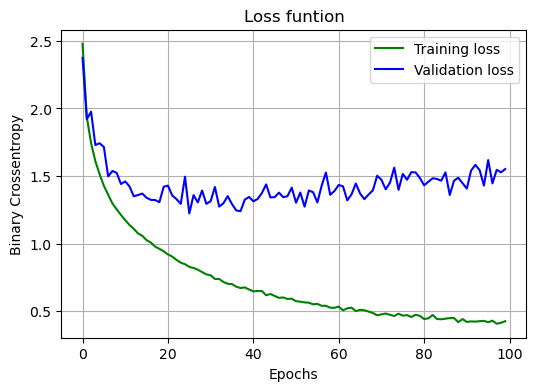

In [ ]:
# loss outputs
plt.figure(figsize=(6, 4))
loss = history.history["loss"]
val_loss = history.history['val_loss']
    
plt.plot(history.epoch, loss, 'g', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Loss funtion')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

plt.show()

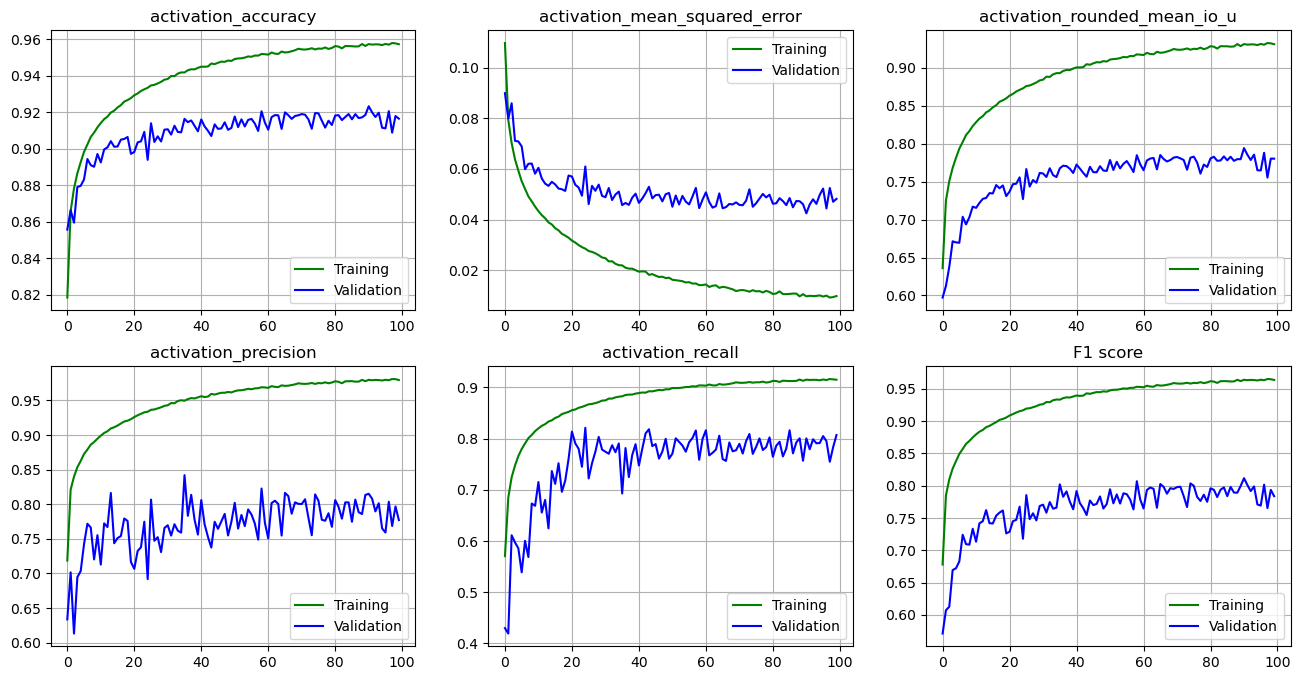

In [ ]:
# metrics
metrics_titles_list = [
    "activation_accuracy", 
    "activation_mean_squared_error", 
    "activation_rounded_mean_io_u", 
    "activation_precision", 
    "activation_recall"
]

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.ravel()

for i, metrics_name in enumerate(metrics_titles_list):
    metrics = history.history[metrics_name]
    val_metrics = history.history['val_' + metrics_name]
    
    axs[i].plot(history.epoch, metrics, 'g', label='Training')
    axs[i].plot(history.epoch, val_metrics, 'b', label='Validation')
    axs[i].set_title(metrics_name)
    axs[i].legend()
    axs[i].grid()
    
f1_scores = list(map(lambda x: FBetaScore(x[0], x[1], 0.3), zip(history.history['activation_precision'], history.history['activation_recall'])))
val_f1_scores = list(map(lambda x: FBetaScore(x[0], x[1], 0.3), zip(history.history['val_activation_precision'], history.history['val_activation_recall'])))
axs[5].plot(history.epoch, f1_scores, 'g', label='Training')
axs[5].plot(history.epoch, val_f1_scores, 'b', label='Validation')
axs[5].set_title('F1 score')
axs[5].legend()
axs[5].grid()

plt.show()

In [6]:
best_saved_model = keras.models.load_model('./serving/models/u2net/2')

In [ ]:
display_model_predictions(best_saved_model)

In [4]:
latest_saved_model = keras.models.load_model('./serving/models/u2net/1')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-27 12:20:09.670843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 12:20:09.671581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


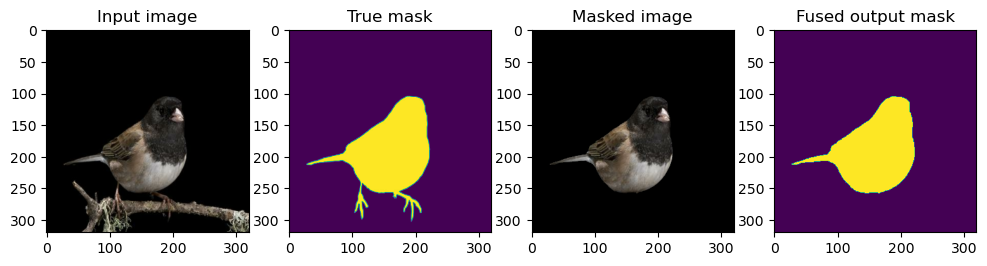

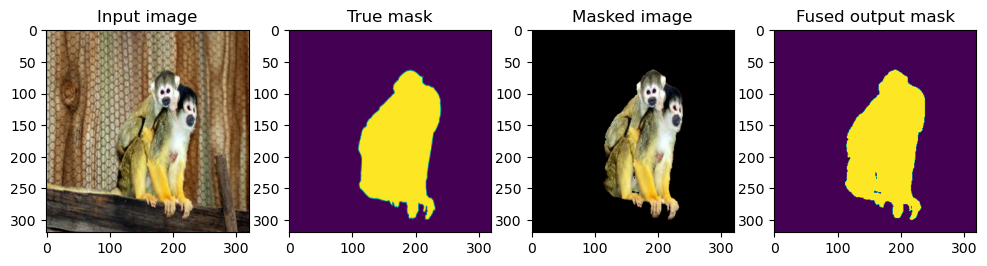

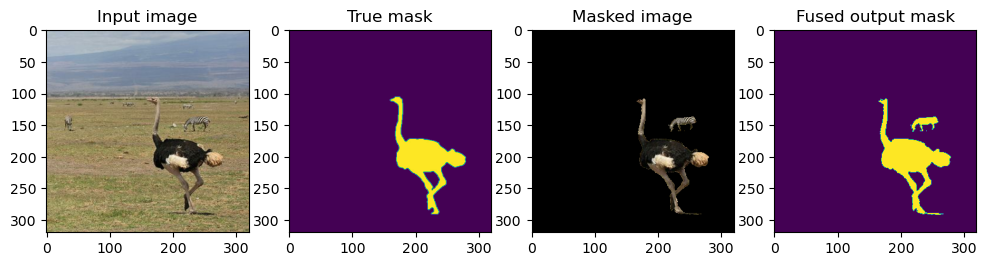

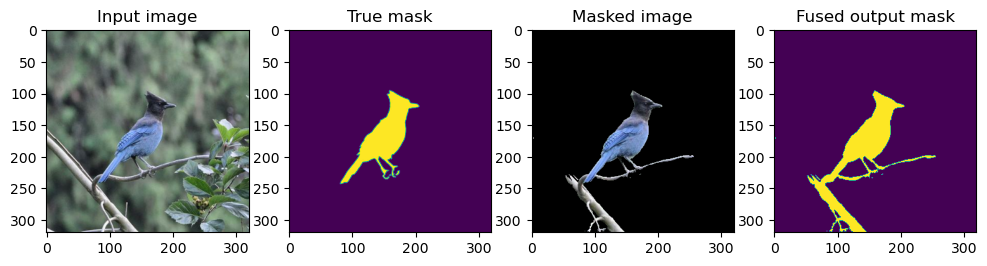

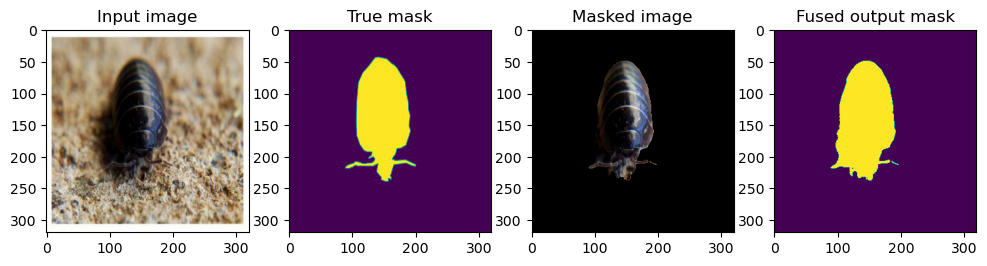

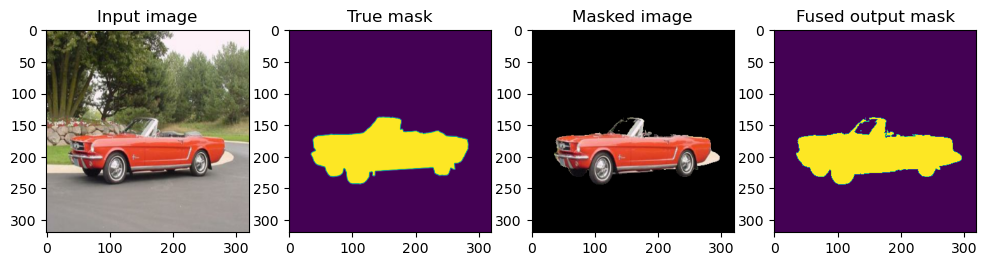

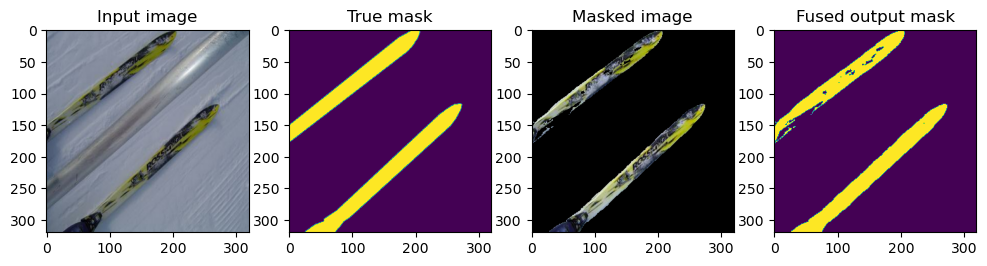

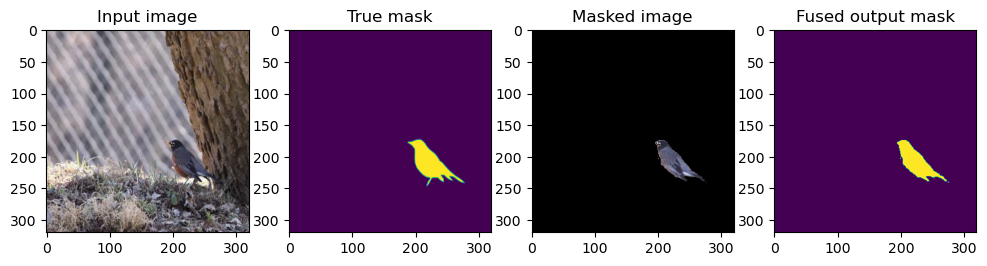

In [16]:
display_model_predictions(latest_saved_model)

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./logs